## **MINI-PROJET 1 :** Prédiction du risque d'abandon scolaire

### **Consignes**

1. **Prétraitement des données :** gérer les variables catégorielles, vérifier les valeurs manquantes, explorer la distribution des variables.


2. **Exploration des corrélations** et visualisation des données (PCA ?).


3. **Choix d’un ou plusieurs modèles de classification** parmi ceux étudiés (KNN, arbre de décision, régression logistique, KMeans).


4. **Évaluation des performances :** utilisez accuracy, recall, precision, f1-score et matrice de confusion.


5. **Recherche des meilleurs hyperparamètres** avec GridSearch et validation croisée.


6. **Analyse critique des résultats :**
- Quels modèles fonctionnent le mieux ? Pourquoi ?
- Quelles sont les limites du modèle ? Des données ?
- Quelle interprétation peut-on faire des métriques obtenues ?
- Que signifie une bonne ou mauvaise précision dans ce contexte ?


**Attention : la partie interprétation comptera pour 50% de la note finale.** Il ne s’agit pas uniquement d’écrire du code mais de démontrer votre compréhension du problème.

### **1. Prétraitement des données**

In [3]:
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import plot_tree
from sentence_transformers import SentenceTransformer

data_df = pandas.read_csv("Dataset_Abandon_Scolaire.csv")

data_df

,Age,Sexe,Taux_presence,Nombre_retards,Note_moyenne,Situation_familiale,Abandon
0,21,Femme,89.585023,2,15.826896,Enfants à charge,0
1,20,Homme,70.713068,3,12.829358,Célibataire,0
2,22,Femme,82.122963,1,13.086319,Enfants à charge,0
3,24,Homme,87.408859,3,14.992032,Célibataire,0
4,20,Homme,86.470676,3,12.671649,Marié,0
...,...,...,...,...,...,...,...
1995,23,Femme,81.800974,3,12.496245,Marié,0
1996,20,Homme,84.082873,4,13.125663,Célibataire,0
1997,19,Femme,87.114146,1,13.841282,Célibataire,0
1998,20,Femme,83.799064,3,12.061256,Célibataire,0


Gestion des variables catégorielles :

In [4]:
problem = data_df.drop("Abandon", axis=1)
target = data_df["Abandon"]

categorial_features = ["Sexe", "Situation_familiale"]
numeric_features = ["Age", "Taux_presence", "Nombre_retards", "Note_moyenne"]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorial_features)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

problem_transformed = preprocessor.fit_transform(data_df)

encoded_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorial_features)
all_columns = list(encoded_columns) + numeric_features + ["Abandon"]

transformed_df = pandas.DataFrame(problem_transformed.toarray() if hasattr(problem_transformed, 'toarray') else problem_transformed, columns=all_columns)


Normalisation standard des données

In [5]:
standard_scaler_object = StandardScaler()
normalized_problem = standard_scaler_object.fit_transform(problem_transformed)

Vérification des valeurs manquantes :

In [6]:
data_df.apply(lambda x: x=="?", axis=0).sum()

Age                    0
Sexe                   0
Taux_presence          0
Nombre_retards         0
Note_moyenne           0
Situation_familiale    0
Abandon                0
dtype: int64

Il n'y a pas de valeurs manquantes dans le jeu de données.

Nombre de personnes en situation d'abandon scolaire :

In [7]:
data_df[["Abandon"]].value_counts()

Abandon
0          1832
1           168
Name: count, dtype: int64

On remarque que sur 2000 personnes, 168 (soit 8,4%) sont en situation d'abandon scolaire.

### **2. Exploration des corrélations**

Matrice de corrélation :

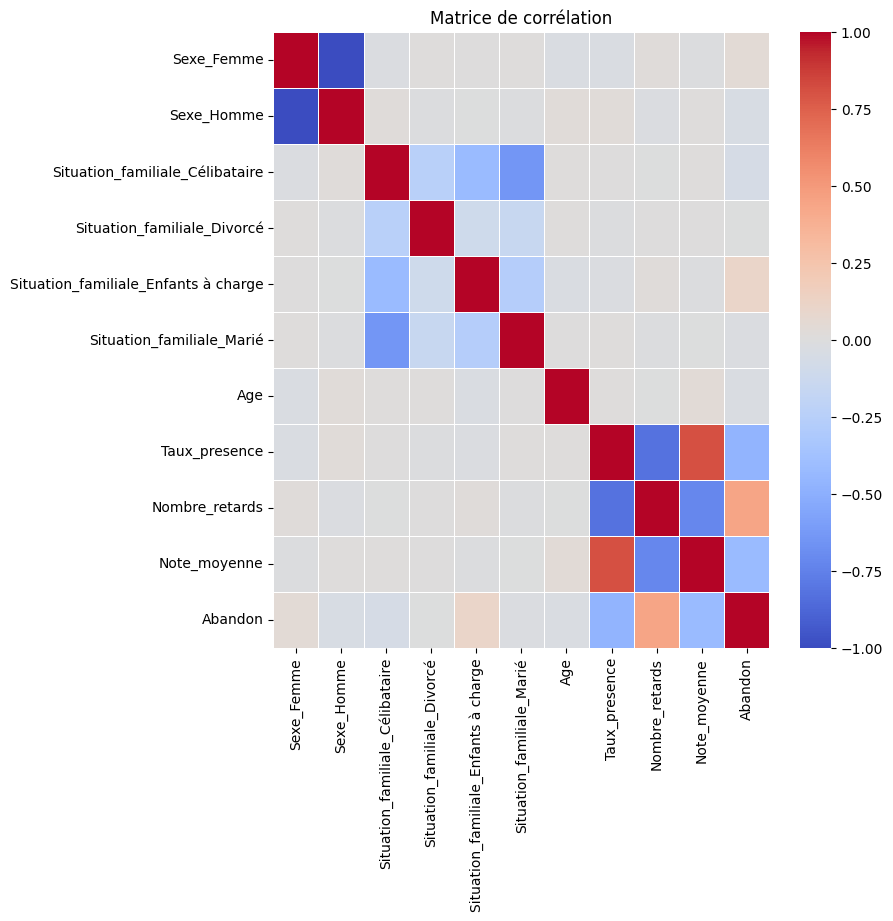

In [8]:
corr_matrix = transformed_df.corr()
plt.figure(figsize=(8, 8))
seaborn.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Matrice de corrélation")
plt.show()

Ici nous pouvons observer plusieurs corrélations positives entre différents champs :
- Plus la note moyenne est élevée, plus le taux de présence est élevé
- Plus le nombre de retards est élevé, plus le risque d'abandon scolaire augmente.

À l'inverse on observe plusieurs corrélations négatives :
- Plus le nombre de retards est élevé, plus le taux de présence est faible
- Plus la nombre de retards est élevé, plus la note moyenne est basse
- Plus le taux de présence est élevé, plus le riques d'abandon scolaire diminue
- Plus la note moyenne est élevée, plus le risque d'abandon scolaire est faible.

PCA (analyse en composantes principales) :

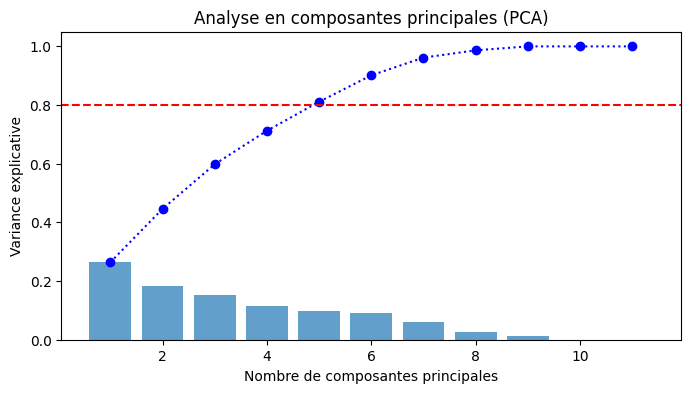

In [9]:
pca_object = PCA()
principal_components_problem = pca_object.fit_transform(normalized_problem)

explained_variance = pca_object.explained_variance_ratio_
cumulative_variance = numpy.cumsum(explained_variance)

plt.figure(figsize=(8,4))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='explained_variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, "bo:", label='cumulative_variance')
plt.axhline(y=0.8, color="red", linestyle="--", label="80% d'information utile")
plt.title("Analyse en composantes principales (PCA)")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance explicative")
plt.show()

D'après le graphe ci-dessus, on remarque que les 5 premières composantes principales (PC1 à PC5) cumulées capturent 80% des informations utiles. Autrement dit, nous pouvons réduire la dimension du jeu de données à 5 variables en minimisant la perte d'information.

### **3. Choix d'un ou plusieurs modèles de classification**

Arbre de décision :

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'classifier__criterion': 'entropy', 'classifier__max_depth': np.int64(1), 'classifier__min_samples_leaf': np.int64(15)}
    mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0        0.039470      0.019093  ...        0.063345                5
1        0.015730      0.006289  ...        0.063345                5
2        0.013892      0.002469  ...        0.063345                5
3        0.016827      0.005459  ...        0.063345                5
4        0.023879      0.008792  ...        0.063345                5
..            ...           ...  ...             ...              ...
91       0.012956      0.001048  ...        0.043904               70
92       0.014575      0.001251  ...        0.047533               26
93       0.013387      0.001312  ...        0.072670               80
94       0.014622      0.003148  ...        0.065467               14
95       0.016160      0.001413  ...        0.0

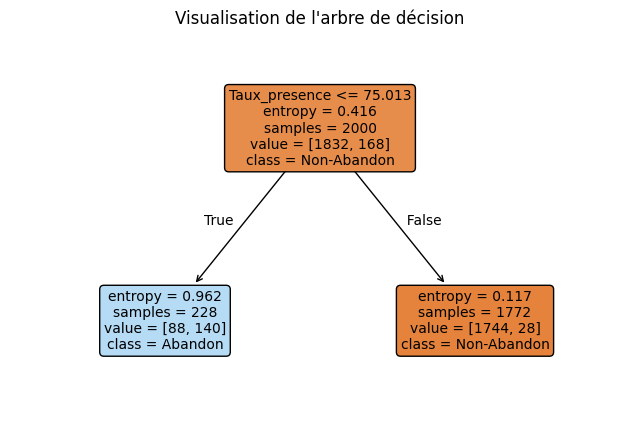

In [12]:
def get_optimal_parameters_decision_tree(problem, target):
    n_folds = 5
    parameters = {"classifier__max_depth" : numpy.arange(1, 13),
                  "classifier__min_samples_leaf" : numpy.arange(15, 75, 15),
                  "classifier__criterion" : ["gini", "entropy"]}
    grid_search_object = GridSearchCV(pipeline, 
                                      parameters,
                                      cv=n_folds,
                                      scoring="f1",
                                      verbose=True)
    grid_search_object.fit(problem, target)
    print(grid_search_object.best_params_)
    scores = pandas.DataFrame(grid_search_object.cv_results_)
    best_model = grid_search_object.best_estimator_
    return best_model, scores

best_model, scores = get_optimal_parameters_decision_tree(problem, target)

print(scores)

classifier = best_model.named_steps["classifier"]

plt.figure(figsize=(8, 5))
plot_tree(classifier,
          feature_names=all_columns,
          class_names=["Non-Abandon", "Abandon"],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Visualisation de l'arbre de décision")
plt.show()

D'après l'arbre de décision, le taux de présence est la variable la plus discriminante.
En effet, 228 personnes présentent un taux de présence inférieur ou égal à 75.013%, tandis que 1772 personnes ont un taux de présence supérieur à ce seuil.

Parmi le 1er groupe (taux de présence ≤ 75.013%), 140 individus, soit environ 61%, sont en situation d'abandon scolaire.

À l'inverse, dans le 2ème groupe (taux de présence > 75.013%), seulement 28 individus, soit environ 1.58%, sont en situation d'abandon scolaire.
 

### **4. Evaluation des performances**

Classification report : 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       463
           1       0.72      0.84      0.78        37

    accuracy                           0.96       500
   macro avg       0.85      0.91      0.88       500
weighted avg       0.97      0.96      0.97       500



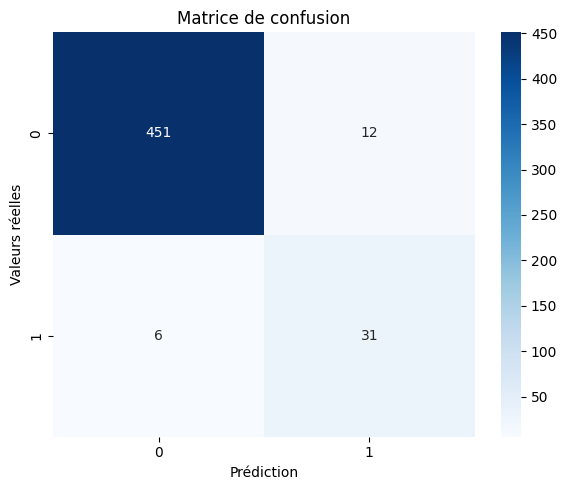

In [11]:
X_train, X_test, y_train, y_test = train_test_split(problem, target, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(f'Classification report : \n{classification_report(y_test, y_pred)}')

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')
plt.xlabel('Prédiction')
plt.ylabel('Valeurs réelles')
plt.tight_layout()
plt.show()

Le rapport de classification montre que :
- Pour les "non-abandon" (0) :
    - Precision = 0.99 : parmi les cas prédits comme non-abandon, 99% étaient corrects
    - Recall = 0.97 : sur tous les vrais cas de non-abandon, 97% ont bien été identifiés.
    - F1-score : moyenne géométrique de la precision et du recall

- Pour les "abandon" (1) :
    - Precision = 0.72 : parmi les cas prédits comme abandon, 72% étaient corrects
    - Recall = 0.84 : sur tous les vrais cas d'abandon, 84% ont bien été identifiés.
    - F1-score : moyenne géométrique de la precision et du recall

La matrice de confusion montre qu'il y a :
- TP = 31
- TN = 451
- FP = 12
- FN = 6

On remarque que globalement le modèle se trompe peu. Toutefois, 6 cas d'abandon scolaire n'ont pas été détectés (FN) ce qui peut être problématique. De même, 12 personnes sont considérées à tort comme étant en situation d'abandon scolaire (FP).

### **5. Recherche des meilleurs hyperparamètres**

Pour rechercher les meilleurs hyperparamètres nous avons utilisé le GridSearch pour la question 3.

### **6. Analyse critique des résultats**

- **Quels modèles fonctionnent le mieux ? Pourquoi ?**

Le modèle "Arbre de décision" fonctionne mieux ici car il est capable de gérer les valeurs numériques et catégorielles. De plus, les arbres de décision peuvent être visualisés facilement et offrent une compréhension intuitive des décisions prises par le modèle.

 

- **Quelles sont les limites du modèle ? Des données ?**

Les limites du modèles peuvent être le surapprentissage. En effet, ce modèle peut sur-ajuster les données d'entraînement, capturant le bruit au lieu de signaler des tendances sous-jacentes. De plus, le modèle peut être biaisé envers les classes dominantes.

Le jeu de données est très déséquilibré : 1832 (91.6%) cas de non-abandon contre 168 (8.4%) cas d'abandon, ce qui peut biaiser les modèles de classification.

 

- **Quelle interprétation peut-on faire des métriques obtenues ?**

    - Accuracy : on remarque que la proportion des bonnes prédictions sur le total des prédictions est de 96% ce qui montre que le modèle prédit correctement dans 96% des cas. Toutefois, étant donné que le jeu de données est déséquilibré, l'accuracy n'est pas très fiable.

    - Precision : cette métrique est égale à 0.72, autrement dit 72% des prédictions d'abandon étaient correctes.

    - Recall : cette métrique est égale à 0.84, autement dit 84% des cas d'abandon ont été détectés par le modèle.

    - F1-score : celle-ci est égale à 0.78, autrement dit il existe un bon équilibre entre les faux positifs et les faux négatifs.

 

- **Que signifie une bonne ou mauvaise précision dans ce contexte ?**

Dans ce contexte, une bonne precision siginifie que le nombre de faux positifs (personnes considérées à tort comme étant en situation d'abandon scolaire) est moindre. À l'inverse, une mauvaise precision indique que le nombre de faux positifs est élevé. 
